# Model 3 - Bidirectional LSTM

In [1]:
from matplotlib import pyplot as plt

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import numpy as np

import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
!python --version

Python 3.9.16


In [3]:
tf. __version__

'2.12.0'

# 1. Load data

In [5]:
# Load and split into training and validation datasets
dataset = tfds.load('squad/v1.1')
train_ds = dataset['train']
val_ds = dataset['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/squad/v1.1/3.0.0.incompleteS8GPBU/squad-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/squad/v1.1/3.0.0.incompleteS8GPBU/squad-validation.tfrecord*...:   0%|    …

Dataset squad downloaded and prepared to /root/tensorflow_datasets/squad/v1.1/3.0.0. Subsequent calls will reuse this data.


In [6]:
# Extract relevant data from training and validation datasets
def extract_data(instance):
    paragraph = instance['context']
    question = instance['question']
    answer = instance['answers']['text'][0]
    return paragraph, question, answer

train_ds = pd.DataFrame(train_ds.map(extract_data).as_numpy_iterator())
val_ds = pd.DataFrame(val_ds.map(extract_data).as_numpy_iterator())

headers = ['Paragraph', 'Question', 'Answer']
train_ds.columns = headers
val_ds.columns = headers

In [7]:
train_ds.head()

,Paragraph,Question,Answer
0,b'The difference in the above factors for the ...,b'What is one use that would require an antenn...,b'mobile phones'
1,"b""The coronation of Charlemagne as emperor on ...",b'About how many counts existed in the Carolin...,b'300'
2,b'Plant responses to climate and other environ...,b'How can climate changes be determined from s...,b'fossil pollen deposits in sediments'
3,b'The Tucson metro area is served by many loca...,"b""What is Tucson's Fox station?""",b'KMSB-TV 11'
4,"b""Situated on one of the world's largest natur...",b'What is the size of New York City in square ...,b'305'


# 2. Pre-processing

## 2.1. Tokenization

In [8]:
def tokenize(text):
    return word_tokenize(text.decode('utf-8'))

train_ds = train_ds.applymap(tokenize)
val_ds = val_ds.applymap(tokenize)

In [9]:
train_ds.head()

,Paragraph,Question,Answer
0,"[The, difference, in, the, above, factors, for...","[What, is, one, use, that, would, require, an,...","[mobile, phones]"
1,"[The, coronation, of, Charlemagne, as, emperor...","[About, how, many, counts, existed, in, the, C...",[300]
2,"[Plant, responses, to, climate, and, other, en...","[How, can, climate, changes, be, determined, f...","[fossil, pollen, deposits, in, sediments]"
3,"[The, Tucson, metro, area, is, served, by, man...","[What, is, Tucson, 's, Fox, station, ?]","[KMSB-TV, 11]"
4,"[Situated, on, one, of, the, world, 's, larges...","[What, is, the, size, of, New, York, City, in,...",[305]


In [10]:
# Compute maximum length statistics for paragraph and question
paragraph_length = max(train_ds['Paragraph'].map(len).max(), val_ds['Paragraph'].map(len).max())
question_length = max(train_ds['Question'].map(len).max(), val_ds['Question'].map(len).max())
print('Max paragraph length:', paragraph_length)
print('Max question length:', question_length)

Max paragraph length: 766
Max question length: 60


## 2.2. Encode answers

In [11]:
num_not_found = 0
not_found = []

# Map answer tokens to one-hot encodings of start and end positions of the answer span extracted from the paragraph
def encode_answer(paragraph_tokens, answer_tokens):
    global num_not_found, not_found
    answer_ptr = 0
    start_pos = None
    end_pos = None
    for i, paragraph_token in enumerate(paragraph_tokens):
        if paragraph_token == answer_tokens[answer_ptr]:
            if start_pos == None:
                start_pos = i
            answer_ptr += 1
            if answer_ptr == len(answer_tokens):
                end_pos = i
                break
        elif start_pos != None:
            start_pos = None
            end_pos = None

    start = [0] * paragraph_length
    end = [0] * paragraph_length

    if start_pos == None or end_pos == None:
        num_not_found += 1
        not_found.append([paragraph_tokens, answer_tokens])
    else:
        start[start_pos] = 1
        end[end_pos] = 1
    return [start, end]

train_ds['Answer'] = train_ds.apply(lambda row: encode_answer(row['Paragraph'], row['Answer']), axis=1)
val_ds['Answer'] = val_ds.apply(lambda row: encode_answer(row['Paragraph'], row['Answer']), axis=1)

In [12]:
train_ds.head()

,Paragraph,Question,Answer
0,"[The, difference, in, the, above, factors, for...","[What, is, one, use, that, would, require, an,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[The, coronation, of, Charlemagne, as, emperor...","[About, how, many, counts, existed, in, the, C...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[Plant, responses, to, climate, and, other, en...","[How, can, climate, changes, be, determined, f...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[The, Tucson, metro, area, is, served, by, man...","[What, is, Tucson, 's, Fox, station, ?]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[Situated, on, one, of, the, world, 's, larges...","[What, is, the, size, of, New, York, City, in,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# 3. Embeddings - GloVe

In [13]:
embedding_file = 'glove.6B.50d.txt'
embedding_size = 50

# Pre-computed unknown vector (by taking average of all word vectors)
# Reference: https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt
unknown_vector = np.array([-0.12920076, -0.28866628, -0.01224866, -0.05676644, -0.20210965, -0.08389011,
    0.33359843,  0.16045167,  0.03867431,  0.17833012,  0.04696583, -0.00285802,
    0.29099807,  0.04613704,  -0.20923874, -0.06613114, -0.06822549, 0.07665912,
    0.3134014,   0.17848536,  -0.1225775,  -0.09916984, -0.07495987, 0.06413227,
    0.14441176,  0.60894334,  0.17463093,  0.05335403,  -0.01273871, 0.03474107,
    -0.8123879,  -0.04688699, 0.20193407,  0.2031118,   -0.03935686, 0.06967544,
    -0.01553638, -0.03405238, -0.06528071, 0.12250231,  0.13991883, -0.17446303,
    -0.08011883, 0.0849521,   -0.01041659, -0.13705009, 0.20127155, 0.10069408,
    0.00653003,  0.01685157], np.float32)

In [14]:
# Build embedding dictionary
embeddings = {}
with open(embedding_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word, vector = values[0], np.asarray(values[1:], np.float32)
        embeddings[word] = vector

In [15]:
# Transform word tokens into word embeddings
def embed(tokens):
    vectors = []
    for token in tokens:
        token = token.lower()
        if token in embeddings:
            vectors.append(embeddings[token])
        else:
            vectors.append(unknown_vector)
    return np.asarray(vectors, np.float32)

train_ds['Paragraph'], train_ds['Question'] = train_ds['Paragraph'].map(embed), train_ds['Question'].map(embed)
val_ds['Paragraph'], val_ds['Question'] = val_ds['Paragraph'].map(embed), val_ds['Question'].map(embed)

In [16]:
train_ds.head()

,Paragraph,Question,Answer
0,"[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -...","[[0.45323, 0.059811, -0.10577, -0.333, 0.72359...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -...","[[0.89466, 0.36604, 0.37588, -0.41818, 0.58462...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[1.3168, 0.33647, 0.23596, 0.94903, -0.3139, ...","[[0.68938, -0.10644, 0.17083, -0.37583, 0.7517...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -...","[[0.45323, 0.059811, -0.10577, -0.333, 0.72359...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0.98389, 0.9686, -0.39243, -0.11845, 0.47929...","[[0.45323, 0.059811, -0.10577, -0.333, 0.72359...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


# 4. Prepare training and validation data

In [17]:
# Pad paragraph and question embeddings
def pad_paragraph(vectors):
    remaining_length = paragraph_length - len(vectors)
    paddings = np.repeat([np.zeros(embedding_size)], remaining_length, axis=0)
    return np.concatenate((vectors, paddings), axis=0, dtype=np.float32)

def pad_question(vectors):
    remaining_length = question_length - len(vectors)
    paddings = np.repeat([np.zeros(embedding_size)], remaining_length, axis=0)
    return np.concatenate((vectors, paddings), axis=0, dtype=np.float32)

paragraph_train = train_ds['Paragraph'].map(pad_paragraph).to_list()
question_train = train_ds['Question'].map(pad_question).to_list()

paragraph_val = val_ds['Paragraph'].map(pad_paragraph).to_list()
question_val = val_ds['Question'].map(pad_question).to_list()

In [18]:
# Get start and end token positions
answer_train = train_ds['Answer'].to_list()
start_train = [ans[0] for ans in answer_train]
end_train = [ans[1] for ans in answer_train]

answer_val = val_ds['Answer'].to_list()
start_val = [ans[0] for ans in answer_val]
end_val = [ans[1] for ans in answer_val]

In [19]:
# Convert to constant tensor
paragraph_train, question_train = tf.constant(paragraph_train, np.float32), tf.constant(question_train, np.float32)
paragraph_val, question_val = tf.constant(paragraph_val, np.float32), tf.constant(question_val, np.float32)
start_train, end_train = tf.constant(start_train, np.float32), tf.constant(end_train, np.float32)
start_val, end_val = tf.constant(start_val, np.float32), tf.constant(end_val, np.float32)

# 5. Feature Extraction - Bidirectional LSTM encoder

In [20]:
# LSTM encoder layer for paragraph
paragraph_inputs = tf.keras.Input(shape=(paragraph_length, embedding_size))
paragraph_inputs = tf.keras.layers.Masking(mask_value=np.zeros(embedding_size))(paragraph_inputs)
paragraph_encoded = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_size, return_sequences=True))(paragraph_inputs)

# LSTM encoder layer for question
question_inputs = tf.keras.Input(shape=(question_length, embedding_size))
question_inputs = tf.keras.layers.Masking(mask_value=np.zeros(embedding_size))(question_inputs)
question_encoded = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_size, return_sequences=True))(question_inputs)

# 6. Paragraph-Question Interaction - Bidirectional attention + One-hop interaction

In [21]:
# Co-attention layer
scores = tf.matmul(paragraph_encoded, question_encoded, transpose_b=True)
question_weights = tf.nn.softmax(scores)
paragraph_weights = tf.nn.softmax(tf.transpose(scores, perm=[0,2,1]))
question_context = tf.matmul(paragraph_encoded, question_weights, transpose_a=True)
question_concat = tf.concat([tf.transpose(question_encoded, perm=[0,2,1]), question_context], axis=1)
paragraph_context = tf.transpose(tf.matmul(question_concat, paragraph_weights), perm=[0,2,1])

# 7. Span prediction - Unidirectional boundary model

In [22]:
# Answer pointer layer
boundary = tf.keras.layers.LSTM(embedding_size, return_sequences=True)(paragraph_context)
start_pos_logits = tf.keras.layers.Dense(1)(boundary)
boundary = tf.keras.layers.Concatenate()([boundary, start_pos_logits])
end_pos_logits = tf.keras.layers.Dense(1)(boundary)

start_pos_distribution = tf.keras.layers.Softmax()(tf.squeeze(start_pos_logits, axis=-1))
end_pos_distribution = tf.keras.layers.Softmax()(tf.squeeze(end_pos_logits, axis=-1))

# 8. Build, fit and evaluate model

In [23]:
def cross_entropy_loss(y_true, y_pred):
    start_true, end_true = y_true[0], y_true[1]
    start_pred, end_pred = y_pred[0], y_pred[1]

    start_loss = -tf.reduce_sum(start_true * tf.math.log(start_pred))
    end_loss = -tf.reduce_sum(end_true * tf.math.log(end_pred))

    total_loss = start_loss + end_loss
    return total_loss

def exact_match(y_true, y_pred):
    start_true, end_true = tf.math.argmax(y_true[0], output_type=tf.int32), tf.math.argmax(y_true[1], output_type=tf.int32)
    start_pred = tf.math.argmax(y_pred[0], output_type=tf.int32)
    end_pred = start_pred + tf.math.argmax(y_pred[1][start_pred:], output_type=tf.int32)

    if start_pred != start_true or end_pred != end_true:
        return float(0)
    else:
        return float(1)

def f1_score(y_true, y_pred):
    start_true, end_true = tf.math.argmax(y_true[0], output_type=tf.int32), tf.math.argmax(y_true[1], output_type=tf.int32)
    start_pred = tf.math.argmax(y_pred[0], output_type=tf.int32)
    end_pred = start_pred + tf.math.argmax(y_pred[1][start_pred:], output_type=tf.int32)

    start_min = tf.math.minimum(start_true, start_pred)
    end_max = tf.math.maximum(end_true, end_pred)

    true_pos = 0
    false_neg = 0
    false_pos = 0

    for pos in range(start_min, end_max + 1):
        in_true = start_true <= pos <= end_true
        in_pred = start_pred <= pos <= end_pred

        if in_true:
            if in_pred:
                true_pos += 1
            else:
                false_neg += 1
        else:
            if in_pred:
                false_pos += 1

    if true_pos == 0 and false_neg == 0 and false_pos == 0:
        return float(0)

    return float((2 * true_pos) / (2 * true_pos + false_pos + false_neg))

model = tf.keras.Model(inputs=[paragraph_inputs, question_inputs], outputs =[start_pos_distribution, end_pos_distribution])
model.compile(optimizer='adam', loss=cross_entropy_loss, metrics=[exact_match, f1_score])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 60, 50)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 766, 50)]    0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 60, 100)     40400       ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional (Bidirectional)  (None, 766, 100)     40400       ['input_3[0][0]']            

In [24]:
epochs = 30
history = model.fit(
    [paragraph_train, question_train],
    [start_train, end_train],
    epochs=epochs,
    validation_data=([paragraph_val, question_val], [start_val, end_val])
)

Epoch 1/30
2738/2738 [==============================] - 302s 104ms/step - loss: 17.5767 - softmax_loss: 8.8291 - softmax_1_loss: 8.7476 - softmax_exact_match: 0.0022 - softmax_f1_score: 0.0867 - softmax_1_exact_match: 0.0029 - softmax_1_f1_score: 0.1004 - val_loss: 16.5422 - val_softmax_loss: 8.4032 - val_softmax_1_loss: 8.1390 - val_softmax_exact_match: 0.0030 - val_softmax_f1_score: 0.1413 - val_softmax_1_exact_match: 0.0000e+00 - val_softmax_1_f1_score: 0.1569
Epoch 2/30
2738/2738 [==============================] - 270s 99ms/step - loss: 15.9209 - softmax_loss: 8.1751 - softmax_1_loss: 7.7457 - softmax_exact_match: 0.0044 - softmax_f1_score: 0.1389 - softmax_1_exact_match: 0.0040 - softmax_1_f1_score: 0.1509 - val_loss: 16.0575 - val_softmax_loss: 8.3041 - val_softmax_1_loss: 7.7535 - val_softmax_exact_match: 0.0000e+00 - val_softmax_f1_score: 0.1665 - val_softmax_1_exact_match: 0.0000e+00 - val_softmax_1_f1_score: 0.1414
Epoch 3/30
2738/2738 [==============================] - 271s 

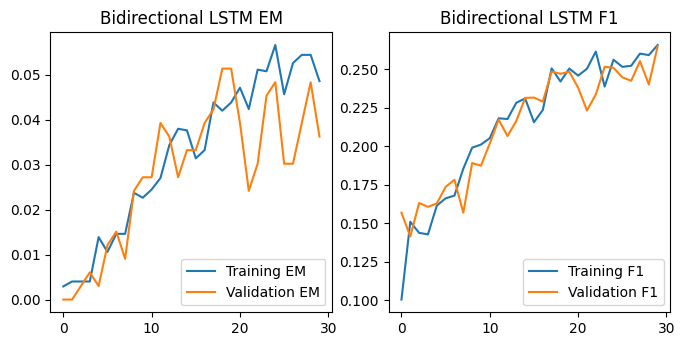

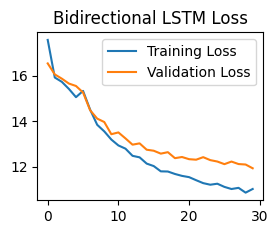

In [25]:
em = history.history['softmax_1_exact_match']
f1 = history.history['softmax_1_f1_score']
loss = history.history['loss']

val_em = history.history['val_softmax_1_exact_match']
val_f1 = history.history['val_softmax_1_f1_score']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, em, label='Training EM')
plt.plot(epochs_range, val_em, label='Validation EM')
plt.legend(loc='lower right')
plt.title('Bidirectional LSTM EM')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, f1, label='Training F1')
plt.plot(epochs_range, val_f1, label='Validation F1')
plt.legend(loc='lower right')
plt.title('Bidirectional LSTM F1')
plt.show()

plt.subplot(2, 2, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Bidirectional LSTM Loss')
plt.show()

In [26]:
results = model.predict([paragraph_val, question_val])
predictions = []
for start_dist, end_dist in zip(results[0], results[1]):
    start_pred = np.argmax(start_dist)
    end_pred = start_pred + np.argmax(end_dist[start_pred:])
    predictions.append([start_pred, end_pred])
with open('model3.npy', 'wb') as f:
    np.save(f, np.array(predictions))

331/331 [==============================] - 13s 33ms/step
